<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/Light%20GBM%20demand-forecasting-201904131526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# https://www.kaggle.com/ashishpatel26/light-gbm-demand-forecasting

# Light GBM demand-forecasting

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matchbou","key":"b332de8173f61d7f1a987ce8d0178075"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# kaggleデータ置き場とjupyernoteのカレントディレクトリフォルダを作成

!mkdir ./input
!mkdir ./notebook

In [0]:
#osライブラリ読込してinputに移動⇒kaggleデータもダウンロード　⇒ notebookフォルダに移動
import os
os.chdir('input')



In [17]:
#https://www.kaggle.com/c/demand-forecasting-kernels-only/data
!kaggle competitions download -c demand-forecasting-kernels-only

  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 80.1MB/s]
  0% 0.00/135k [00:00<?, ?B/s]
100% 135k/135k [00:00<00:00, 37.4MB/s]
  0% 0.00/3.08M [00:00<?, ?B/s]
100% 3.08M/3.08M [00:00<00:00, 50.7MB/s]


In [19]:
!unzip sample_submission.csv.zip -d ./
!unzip test.csv.zip -d ./
!unzip train.csv.zip -d ./


Archive:  sample_submission.csv.zip
  inflating: ./sample_submission.csv  
Archive:  test.csv.zip
  inflating: ./test.csv              
Archive:  train.csv.zip
  inflating: ./train.csv             


In [0]:
!mkdir ./demand-forecasting-kernels-only

!mv sample_submission.csv ./demand-forecasting-kernels-only
!mv test.csv   ./demand-forecasting-kernels-only
!mv train.csv      ./demand-forecasting-kernels-only




In [22]:
!pwd
!ls -a ./demand-forecasting-kernels-only

/content/input
.  ..  sample_submission.csv  test.csv	train.csv


In [0]:
#!rm ./* -r

In [0]:
os.chdir('../notebook')

In [24]:
#上記操作の結果以下のディレクトリ配置となる

# /content/notebook このipynbのカレントディレクトリ
# /content/input カグルからダウンロードしたcsvファイルの置き場所

!pwd
!ls -a ../input


/content/notebook
.   demand-forecasting-kernels-only  test.csv.zip
..  sample_submission.csv.zip	     train.csv.zip


In [0]:
#ここからカーネルの内容に踏み込む

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [27]:
#Load the datasets
# Input data files are available in the "../input/" directory.
# First let us load the datasets into different Dataframes
def load_data(datapath):
    data = pd.read_csv(datapath)
   # Dimensions
    print('Shape:', data.shape)
    # Set of features we have are: date, store, and item
    display(data.sample(10))
    return data
    
    
train_df = load_data('../input/demand-forecasting-kernels-only/train.csv')
test_df = load_data('../input/demand-forecasting-kernels-only/test.csv')
sample_df = load_data('../input/demand-forecasting-kernels-only/sample_submission.csv')

Shape: (913000, 4)


,date,store,item,sales
835750,2016-06-22,8,46,98
202956,2013-09-28,2,12,91
635399,2017-11-13,8,35,91
692889,2015-04-16,10,38,111
257721,2013-09-13,2,15,88
507874,2013-09-04,9,28,73
237858,2014-04-24,1,14,55
642659,2017-09-30,2,36,136
707273,2014-09-04,8,39,55
886893,2016-07-07,6,49,21


Shape: (45000, 4)


,id,date,store,item
326,326,2018-02-26,4,1
31152,31152,2018-01-13,7,35
34410,34410,2018-01-31,3,39
44119,44119,2018-01-20,1,50
23046,23046,2018-01-07,7,26
14526,14526,2018-02-06,2,17
12920,12920,2018-02-20,4,15
14189,14189,2018-03-01,8,16
41459,41459,2018-03-01,1,47
9758,9758,2018-02-08,9,11


Shape: (45000, 2)


,id,sales
901,901,52
8806,8806,52
10025,10025,52
43763,43763,52
5100,5100,52
39680,39680,52
23434,23434,52
2032,2032,52
30408,30408,52
27392,27392,52


Time series data exploration
(This portion was forked.)

The goal of this kernel is data exploration of a time-series sales data of store items.
The tools pandas, matplotlib and, plotly are used for slicing & dicing the data and visualizations.

Distribution of sales
Now let us understand how the sales varies across all the items in all the stores

In [28]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.sales, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train_df)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

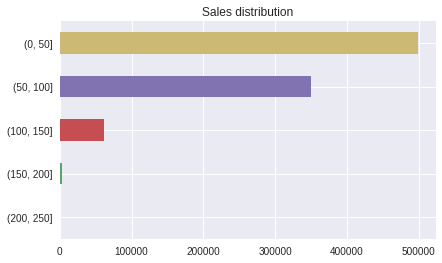

In [29]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

sales                                                         \
item          1          2          3          4          5          6    
store                                                                     
1      19.971522  53.148959  33.208105  19.956188  16.612815  53.060789   
2      28.173604  75.316539  46.992333  28.234940  23.540526  74.945235   
3      25.070099  66.804491  41.771084  25.116101  20.857612  67.007119   
4      22.938664  61.715225  38.548193  23.086528  19.525192  61.270537   
5      16.739321  44.488499  27.835706  16.776561  14.086528  44.564622   
6      16.717963  44.533954  27.811062  16.754107  13.893209  44.503834   
7      15.159365  40.717963  25.531216  15.358160  12.733844  40.703724   
8      26.983571  71.656627  45.076123  26.948521  22.427711  71.958379   
9      23.325849  61.792442  38.535049  23.150055  19.272180  61.412377   
10     24.736035  65.566813  41.113363  24.721249  20.637459  65.612267   

                                                     ...                 \
item          7          8          9          10    ...             41   
store                                                ...                  
1      52.783680  69.472070  46.504929  66.354326    ...      20.002738   
2      75.058598  99.090361  65.478094  94.097481    ...      28.069551   
3      66.647864  87.517525  58.486857  83.387733    ...      24.989047   
4      61.625411  80.819825  54.043812  77.047645    ...      23.168127   
5      44.535597  58.565717  38.837349  55.509858    ...      16.830778   
6      44.599124  58.385542  39.460022  55.565170    ...      16.607338   
7      40.709748  53.723987  35.901972  51.156627    ...      15.471522   
8      71.730559  94.461117  63.193319  89.818182    ...      27.036145   
9      61.812158  81.287514  54.105696  77.105148    ...      23.191128   
10     65.807777  86.176889  57.886637  82.232202    ...      24.654984   

                                                                          \
item          42         43         44          45         46         47   
store                                                                      
1      33.105696  46.242607  26.594195   72.720701  52.845016  19.814348   
2      47.368018  65.785323  37.785871  103.381161  75.219606  28.187842   
3      41.797371  58.197700  33.386090   91.851041  66.748083  25.120482   
4      38.539978  54.018620  30.952355   84.687295  61.420044  23.114458   
5      27.730559  39.163198  22.415115   61.427163  44.734940  16.699343   
6      27.893209  39.034502  22.322563   61.142935  44.539978  16.708653   
7      25.435926  35.426068  20.446331   55.905805  40.828587  15.479189   
8      45.144031  62.980285  36.194414   98.941402  72.004929  27.150055   
9      38.643483  54.152793  30.968237   85.093647  62.010953  23.003286   
10     41.222892  57.942497  32.916758   90.690581  66.046550  24.755750   

                                        
item          48         49         50  
store                                   
1      46.546002  26.461665  59.342826  
2      66.028478  37.711939  84.622125  
3      58.700986  33.259584  74.958379  
4      53.765608  30.840635  68.921687  
5      39.281490  22.371851  50.319277  
6      39.052574  22.181271  50.516429  
7      35.624315  20.406353  45.823658  
8      62.737130  36.035049  80.972070  
9      53.976999  31.052574  69.308324  
10     57.814896  33.032311  74.037240  

[10 rows x 50 columns]

<Figure size 1440x720 with 0 Axes>

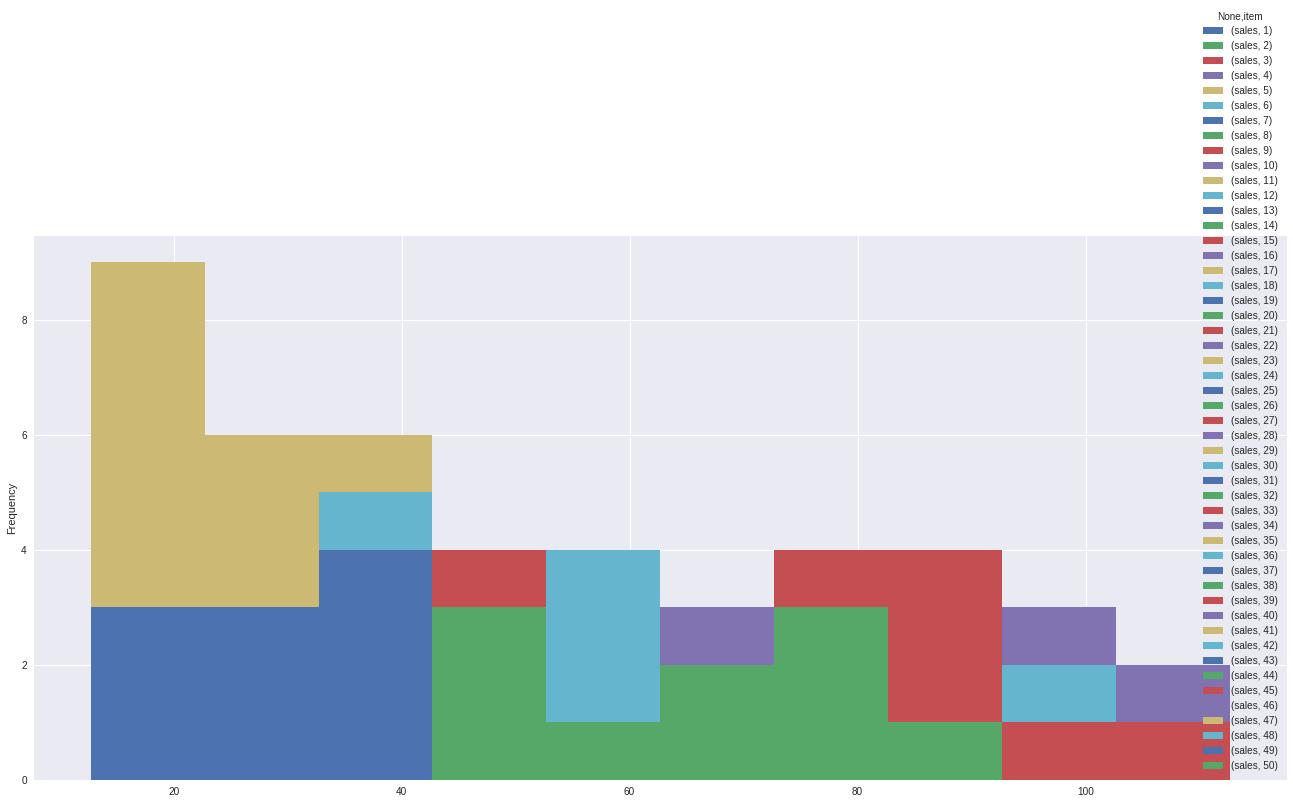

In [30]:
#How does sales vary across stores
#Let us get a overview of sales distribution in the whole data.

# Let us understand the sales data distribution across the stores
def sales_data_understanding(data):    
    store_df = data.copy()
    plt.figure(figsize=(20,10))
    sales_pivoted_df = pd.pivot_table(store_df, index='store', values=['sales','date'], columns='item', aggfunc=np.mean)
    sales_pivoted_df.plot(kind="hist",figsize=(20,10))
    # Pivoted dataframe
    display(sales_pivoted_df)
    return (store_df,sales_pivoted_df)

store_df,sales_pivoted_df = sales_data_understanding(train_df)

In [0]:
# Let us calculate the average sales of all the items by each store
sales_across_store_df = sales_pivoted_df.copy()
sales_across_store_df['avg_sale'] = sales_across_store_df.apply(lambda r: r.mean(), axis=1)

In [32]:
# Scatter plot of average sales per store
sales_store_data = go.Scatter(
    y = sales_across_store_df.avg_sale.values,
    mode='markers',
    marker=dict(
        size = sales_across_store_df.avg_sale.values,
        color = sales_across_store_df.avg_sale.values,
        colorscale='Viridis',
        showscale=True
    ),
    text = sales_across_store_df.index.values
)
data = [sales_store_data]

sales_store_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per store',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Stores',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_store_layout)
py.iplot(fig,filename='scatter_sales_store')

In [33]:
#How does sales vary across items
def sales_insight(sales_pivoted_df):
    # Let us calculate the average sales of each of the item across all the stores
    sales_across_item_df = sales_pivoted_df.copy()
    # Aggregate the sales per item and add it as a new row in the same dataframe
    sales_across_item_df.loc[11] = sales_across_item_df.apply(lambda r: r.mean(), axis=0)
    # Note the 11th index row, which is the average sale of each of the item across all the stores
    #display(sales_across_item_df.loc[11:])
    avg_sales_per_item_across_stores_df = pd.DataFrame(data=[[i+1,a] for i,a in enumerate(sales_across_item_df.loc[11:].values[0])], columns=['item', 'avg_sale'])
    # And finally, sort by avg sale
    avg_sales_per_item_across_stores_df.sort_values(by='avg_sale', ascending=False, inplace=True)
    # Display the top 10 rows
    display(avg_sales_per_item_across_stores_df.head())
    return (sales_across_item_df,avg_sales_per_item_across_stores_df)

sales_across_item_df,avg_sales_per_item_across_stores_df = sales_insight(sales_pivoted_df)

,item,avg_sale
14,15,88.030778
27,28,87.881325
12,13,84.316594
17,18,84.275794
24,25,80.686418


In [34]:
#Great! Let us visualize these average sales per item!

avg_sales_per_item_across_stores_sorted = avg_sales_per_item_across_stores_df.avg_sale.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 55,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 10,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

In [35]:
#Time-series visualization of the sales
#Let us see how sales of a given item in a given store varies in a span of 5 years.

def Time_visualization(data):
    store_item_df = data.copy()
    # First, let us filterout the required data
    store_id = 10   # Some store
    item_id = 40    # Some item
    print('Before filter:', store_item_df.shape)
    store_item_df = store_item_df[store_item_df.store == store_id]
    store_item_df = store_item_df[store_item_df.item == item_id]
    print('After filter:', store_item_df.shape)
    #display(store_item_df.head())

    # Let us plot this now
    store_item_ts_data = [go.Scatter(
        x=store_item_df.date,
        y=store_item_df.sales)]
    py.iplot(store_item_ts_data)
    return store_item_df

store_item_df = Time_visualization(train_df)

Before filter: (913000, 4)
After filter: (1826, 4)


In [36]:
def sales_monthly(data):
    multi_store_item_df = data.copy()
    # First, let us filterout the required data
    store_ids = [1, 1, 1, 1]   # Some stores
    item_ids = [10, 20, 30, 40]    # Some items
    print('Before filter:', multi_store_item_df.shape)
    multi_store_item_df = multi_store_item_df[multi_store_item_df.store.isin(store_ids)]
    multi_store_item_df = multi_store_item_df[multi_store_item_df.item.isin(item_ids)]
    print('After filter:', multi_store_item_df.shape)
    #display(multi_store_item_df)
    # TODO Monthly avg sales

    # Let us plot this now
    multi_store_item_ts_data = []
    for st,it in zip(store_ids, item_ids):
        flt = multi_store_item_df[multi_store_item_df.store == st]
        flt = flt[flt.item == it]
        multi_store_item_ts_data.append(go.Scatter(x=flt.date, y=flt.sales, name = "Store:" + str(st) + ",Item:" + str(it)))
    py.iplot(multi_store_item_ts_data)
    return (multi_store_item_df)

multi_store_item_df = sales_monthly(train_df)

Before filter: (913000, 4)
After filter: (7304, 4)


In [0]:
#LIGHTGBM
def split_data(train_data,test_data):
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])

    train_data['month'] = train_data['date'].dt.month
    train_data['day'] = train_data['date'].dt.dayofweek
    train_data['year'] = train_data['date'].dt.year

    test_data['month'] = test_data['date'].dt.month
    test_data['day'] = test_data['date'].dt.dayofweek
    test_data['year'] = test_data['date'].dt.year

    col = [i for i in test_data.columns if i not in ['date','id']]
    y = 'sales'
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(train_df,test_df)

In [38]:
train_x.shape,train_y.shape,test_x.shape

((730400, 5), (730400,), (182600, 5))

In [0]:
# from bayes_opt import BayesianOptimization
# def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.02, output_process=False):
#     # prepare data
#     train_data = lgb.Dataset(data=X, label=y)
#     # parameters
#     def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#         params = {'application':'regression_l1','num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
#         params["num_leaves"] = int(round(num_leaves))
#         params['feature_fraction'] = max(min(feature_fraction, 1), 0)
#         params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
#         params['max_depth'] = int(round(max_depth))
#         params['lambda_l1'] = max(lambda_l1, 0)
#         params['lambda_l2'] = max(lambda_l2, 0)
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
#         cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
#         return max(cv_result['auc-mean'])
#     # range 
#     lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
#                                             'feature_fraction': (0.1, 0.9),
#                                             'bagging_fraction': (0.8, 1),
#                                             'max_depth': (5, 8.99),
#                                             'lambda_l1': (0, 5),
#                                             'lambda_l2': (0, 3),
#                                             'min_split_gain': (0.001, 0.1),
#                                             'min_child_weight': (5, 50)}, random_state=0)
#     # optimize
#     lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
#     # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
#     # return best parameters
#     return lgbBO.res['max']['max_params']

# opt_params = bayes_parameter_opt_lgb(train_x, train_y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.02)

In [0]:
# opt_params

In [41]:
%%time

def model(train_x,train_y,test_x,test_y,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves': 64,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)
    y_test = model.predict(test_df[col])
    return y_test,model

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.2 µs


In [42]:
%%time
y_test, model = model(train_x,train_y,test_x,test_y,col)

Training until validation scores don't improve for 50 rounds.
[50]	training's mape: 0.18758	valid_1's mape: 0.187771
[100]	training's mape: 0.153659	valid_1's mape: 0.15402
[150]	training's mape: 0.146416	valid_1's mape: 0.146833
[200]	training's mape: 0.140941	valid_1's mape: 0.141614
[250]	training's mape: 0.137457	valid_1's mape: 0.138224
[300]	training's mape: 0.135228	valid_1's mape: 0.136131
[350]	training's mape: 0.133971	valid_1's mape: 0.135038
[400]	training's mape: 0.133425	valid_1's mape: 0.134564
[450]	training's mape: 0.132862	valid_1's mape: 0.134069
[500]	training's mape: 0.132523	valid_1's mape: 0.133813
[550]	training's mape: 0.132242	valid_1's mape: 0.133626
[600]	training's mape: 0.132026	valid_1's mape: 0.133456
[650]	training's mape: 0.131832	valid_1's mape: 0.133329
[700]	training's mape: 0.131673	valid_1's mape: 0.133211
[750]	training's mape: 0.131548	valid_1's mape: 0.133133
[800]	training's mape: 0.131445	valid_1's mape: 0.133077
[850]	training's mape: 0.1313

In [43]:
sample_df['sales'] = y_test
sample_df.to_csv('lgb_bayasian_param.csv', index=False)
sample_df['sales'].head()

0    12.096061
1    13.483620
2    14.597619
3    14.638576
4    15.240216
Name: sales, dtype: float64

In [48]:
!ls -a 
files.download("lgb_bayasian_param.csv") 

.  ..  lgb_bayasian_param.csv


In [44]:
# sub_val-0.132358565029612.csv はないので実行不能
def average(df1):
    avg  = df1
    df2 = pd.read_csv("../input/private/sub_val-0.132358565029612.csv")
    avg['sales'] = (df1["sales"]*0.4 + df2["sales"]*0.6)
    return avg

avg = average(sample_df)
avg.to_csv("Submission.csv", index=False)

FileNotFoundError: ignored